# CS 221 Project - Text Features
Extracting the pertinent text features from the dataset to be used for classifying text.

## Libraries
Using NLTK for NLP-related parts.

In [10]:
import math
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
import numpy as np
import pandas as pd
from typing import Counter

[nltk_data] Downloading package punkt to /Users/cpondoc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/cpondoc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/cpondoc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/cpondoc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Constants
For use in frequency distribution below.

In [11]:
Penn_tags = ["CC","CD", "DT", "EX", "FW", "IN", "JJ", "JJR", "JJS", "LS", "MD", "NN", "NNS", "NNP", "NNPS", "PDT", "POS", "PRP", "PRP$", "RB", "RBR", "RBS", "RP", "TO", "UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ", "WDT", "WP", "WRB"]

## Loading in Data
Using the data from `final_data.csv`, which is generated from `histogram.ipynb`.

In [12]:
main_df = pd.read_csv('../data/percentile_data.csv')

## Features 1 and 2: Lexical Diversity and Length
Calculating the lexical diversity of each document, which we define as: $\frac{\text{number of unique words}}{\text{number of total words}}$. In addition, we define the number of words as a feature.

In [13]:
# Data collection for later
all_views = []
all_lexical_div = []
all_lengths = []

# Iterate each row in the dataframe
for index, row in main_df.iterrows():
    # Calculate lexical diversity
    words = word_tokenize(main_df.at[index, 'transcript'])
    lexical_div = float((len(set(words))) / len(words))
    
    # Set appropriate columns equal
    main_df.at[index, 'length'] = len(words)
    main_df.at[index, 'diversity'] = lexical_div
    
    # Appending for future analysis
    all_views.append(main_df.at[index, 'views'])
    all_lexical_div.append(lexical_div)
    all_lengths.append(len(words))

## Plotting above Features Against Views
Plotting the features against views to see if they may be helpful in determining virality.

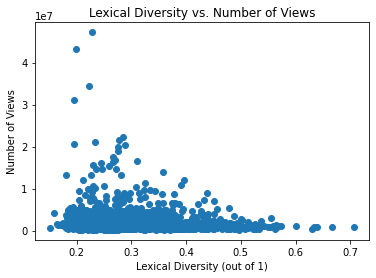

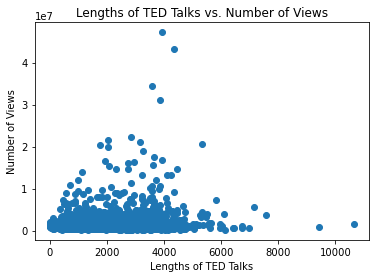

In [14]:
# Graphing Lexical Diversity
plt.title("Lexical Diversity vs. Number of Views")
plt.xlabel("Lexical Diversity (out of 1)")
plt.ylabel("Number of Views")
plt.scatter(all_lexical_div, all_views)
plt.show()

# Graphing Lengths
plt.title("Lengths of TED Talks vs. Number of Views")
plt.xlabel("Lengths of TED Talks")
plt.ylabel("Number of Views")
plt.scatter(all_lengths, all_views)
plt.show()

## Function to Calculate Average Word Length
Utility function to help calculate average word length.

In [15]:
def average_word_length(transcript):
    # Tokneize the transcript
    words = word_tokenize(transcript)
    sum_words = 0
    
    # Calculate sum and append average
    for word in transcript:
        sum_words += len(word)
    return (sum_words / len(words))

## Feature 3: Average Word Length
Below, we calculate average word length as a feature by visualizing of average word length against views and fitting a polynomial distribution. The predicted quantity is then saved as a feature.

Polynomial Distribution Parameters: 
[ -472467.89318331  3350484.31278707 -3465769.83555742]


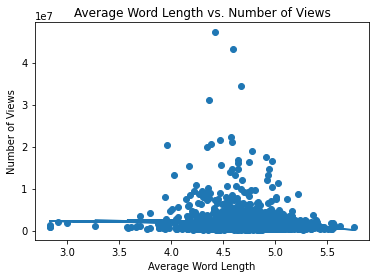

Minimum Predicted Virality 165777.19459976954
Maximum Predicted Virality 2473672.8330126856


In [16]:
# Iterate through each transcript and calculate the average word length
data_length = []
for transcript in main_df['transcript']:
    # Append average length
    average = average_word_length(transcript)
    data_length.append(average)
    
# Set proper data length and views
data_length = np.array(data_length)
data_views = main_df['views']

# Plot the distribution of average word length against views.
plt.title("Average Word Length vs. Number of Views")
plt.xlabel("Average Word Length")
plt.ylabel("Number of Views")
plt.scatter(data_length, data_views)

# Finding the proper polynomial fit
poly_fitter = np.polyfit(data_length, data_views, 2)
print("Polynomial Distribution Parameters: ")
print(poly_fitter)

# Plotting and finding max and min predicted virality
plt.plot(data_length, poly_fitter[0] * (data_length ** 2) + poly_fitter[1] * data_length + poly_fitter[2])
plt.show()
print("Minimum Predicted Virality", min(poly_fitter[0] * (data_length ** 2) + poly_fitter[1] * data_length + poly_fitter[2]))
print("Maximum Predicted Virality", max(poly_fitter[0] * (data_length ** 2) + poly_fitter[1] * data_length + poly_fitter[2]))

# Iterate each row in the dataframe
for index, row in main_df.iterrows():
    # Calculate virality and set corresponding column equal
    average = average_word_length(main_df.at[index, 'transcript'])
    virality = poly_fitter[0] * (average ** 2) + poly_fitter[1] * average + poly_fitter[2]
    main_df.at[index, 'virality'] = virality

## Function to Extract Frequencies
Use NLTK dependencies to calculate the most common nouns, adjectives, and other parts of speech.

In [16]:
def extract_frequencies(title, transcript):
    # Create a dictionary that stores the relevant information for each type
    tag_dictionary = {}
    for tag in Penn_tags:
        tag_dictionary[tag] = []
    transcript_list = word_tokenize(transcript)
    tagged_transcript_list = nltk.pos_tag(transcript_list)
    for word_pairing in tagged_transcript_list:
        if ("'" not in word_pairing[0]) and (word_pairing[1] != "NNP") and (word_pairing[1] != "NNPS"):
            if word_pairing[1] in Penn_tags:
                tag_dictionary[word_pairing[1]].append((word_pairing[0]).lower())

    # Converting all the verbs to the same form
    for word1 in tag_dictionary["VBD"]:
        new_word1 = WordNetLemmatizer().lemmatize(word1,'v')
        tag_dictionary["VB"].append(new_word1)
    tag_dictionary.pop("VBD")
    for word2 in tag_dictionary["VBG"]:
        new_word2 = WordNetLemmatizer().lemmatize(word2,'v')
        tag_dictionary["VB"].append(new_word2)
    tag_dictionary.pop("VBG")
    for word3 in tag_dictionary["VBN"]:
        new_word3 = WordNetLemmatizer().lemmatize(word3,'v')
        tag_dictionary["VB"].append(new_word3)
    tag_dictionary.pop("VBN")
    for word4 in tag_dictionary["VBP"]:
        new_word4 = WordNetLemmatizer().lemmatize(word4,'v')
        tag_dictionary["VB"].append(new_word4)
    tag_dictionary.pop("VBP")
    for word5 in tag_dictionary["VBZ"]:
        new_word5 = WordNetLemmatizer().lemmatize(word5,'v')
        tag_dictionary["VB"].append(new_word5)
    tag_dictionary.pop("VBZ")

    # Converting all the adjectives to the same form
    for word6 in tag_dictionary["JJR"]:
        new_word6 = WordNetLemmatizer().lemmatize(word6,'a')
        tag_dictionary["JJ"].append(new_word6)
    tag_dictionary.pop("JJR")
    for word7 in tag_dictionary["JJS"]:
        new_word7 = WordNetLemmatizer().lemmatize(word7,'a')
        tag_dictionary["JJ"].append(new_word7)
    tag_dictionary.pop("JJS") 

    # Putting all the adverbs into one list (the RB list)
    for word8 in tag_dictionary["RBR"]:
        tag_dictionary["RB"].append(word8)
    tag_dictionary.pop("RBR")
    for word9 in tag_dictionary["RBS"]:
        tag_dictionary["RB"].append(word9)
    tag_dictionary.pop("RBS")

    # Converting all nouns to the same form (add all to NN)
    for word10 in tag_dictionary["NNS"]:
        new_word10 = WordNetLemmatizer().lemmatize(word10)
        tag_dictionary["NN"].append(new_word10)
    tag_dictionary.pop("NNS") 
    for word11 in tag_dictionary["NNP"]:
        new_word11 = WordNetLemmatizer().lemmatize(word11)
        tag_dictionary["NN"].append(new_word11)
    tag_dictionary.pop("NNP")
    for word12 in tag_dictionary["NNPS"]:
        new_word12 = WordNetLemmatizer().lemmatize(word12)
        tag_dictionary["NN"].append(new_word12)
    tag_dictionary.pop("NNPS")

    # Get rid of tags we don't want to analyze
    tag_dictionary.pop("CC")
    tag_dictionary.pop("CD")
    tag_dictionary.pop("DT")
    tag_dictionary.pop("EX")
    tag_dictionary.pop("IN")
    tag_dictionary.pop("LS")
    tag_dictionary.pop("MD")
    tag_dictionary.pop("POS")
    
    # Craft the important ideas
    for key in tag_dictionary:
        tag_dictionary[key] = Counter(tag_dictionary[key]).most_common()
    
    # Return nouns and adjectives
    nouns = tag_dictionary["NN"]
    adjectives = tag_dictionary["JJ"]
    return nouns, adjectives

## Feature 4: Identifying Key Words
Note: we could potentially use the top-$n$ words from the frequncy distribution as our ''keywords'', since they are by far the most common? Just a thought!

In [17]:
# Set null nouns
main_df.at['noun_1'] = ""
main_df.at['noun_2'] = ""
main_df.at['noun_3'] = ""

# Set null adjectives
main_df.at['adjective_1'] = ""
main_df.at['adjective_2'] = ""
main_df.at['adjective_3'] = ""

# Iterate each row in the dataframe
for index, row in main_df.iterrows():
    # Extract the frequencies
    transcript = main_df.at[index, 'transcript']
    title = main_df.at[index, 'title']
    nouns, adjectives = extract_frequencies(title, transcript)
    
    # Set words 1
    if (len(nouns) >= 1):
        main_df.at[index, 'noun_1'] = nouns[0][0]
    else:
        main_df.at[index, 'noun_1'] = ""
    if (len(adjectives) > 1):
        main_df.at[index, 'adjective_1'] = adjectives[0][0]
    else:
        main_df.at[index, 'adjective_1'] = ""
    
    # Set words 2
    if (len(nouns) >= 2):
        main_df.at[index, 'noun_2'] = nouns[1][0]
    else:
        main_df.at[index, 'noun_2'] = ""
    if (len(adjectives) >= 2):
        main_df.at[index, 'adjective_2'] = adjectives[1][0]
    else:
        main_df.at[index, 'adjective_2'] = ""
    
    # Set words 3
    if (len(nouns) >= 3):
        main_df.at[index, 'noun_3'] = nouns[2][0]
    else:
        main_df.at[index, 'noun_3'] = ""
    if (len(adjectives) >= 3):
        main_df.at[index, 'adjective_3'] = adjectives[2][0]
    else:
        main_df.at[index, 'adjective_3'] = ""

## Save All Data
Save final dataframe into a CSV file.

In [18]:
main_df.to_csv('../data/last_data.csv', index=None)